### **Convolutional Neural Networks, and Large Scale Visual Recognition Project**
<em>University of Virginia - Introduction to Computer Vision - Fall 2019 - Vicente Ordonez - vicente@virginia.edu</em><br/><br/>

In this assignment we will apply our knowledge of machine learning and visual recognition using convolutional neural networks to detect various kinds of things from images. 



#### **1. Pytorch on the GPU**
As we deal with increasingly complex models, and larger datasets and image resolutions, we need to be efficient in computing matrix multiplications. In this section we will experiment with GPU computations and how they speed up some computations under certain conditions. Now we are going to test the GPU environment in a task of multiplying two square matrices of size $d\times d$. We provide code below sample code and output for this part but you need to complete the test below.

In [1]:
import torch
import time

# Let's create two matrices of size 4x4 and full of ones.
d = 4000
a = torch.rand(d, d)
b = torch.rand(d, d)

# Compute a dot product between the two matrices in CPU.
start_time = time.time()
output = torch.mm(a,b)  # Regular multiplication in CPU.
cpu_time = time.time() - start_time
print('CPU-time {0:.6f}s'.format(cpu_time))

# Compute a dot product between the two matrices in GPU.
a = a.cuda() # Move to GPU.
b = b.cuda() # Move to GPU.
start_time = time.time()
output = torch.mm(a,b)  # Multiplication happens in GPU.
gpu_time = time.time() - start_time
print('GPU-time {0:.6f}s\n'.format(gpu_time))

print('CPU was {0:.2f}x times the GPU time'.format(cpu_time / gpu_time))

CPU-time 0.937534s
GPU-time 0.002884s

CPU was 325.04x times the GPU time


**Final Comments:** In the GPU code there is a more or less fixed cost of moving tensors to the GPU, this causes using GPUs slower for small tensors counter-productive. Try timing this separately and estimate the cost of this move. Most functions in pytorch have a CUDA implementation so just by moving tensors to the GPU using .cuda() you can perform any operation in a highly parallel manner on a GPU. Moreover, Pytorch supports parallelization on multiple GPUs as well.<br/><br/>

#### **2. Convolutional Neural Networks**
This section will build on the previous project but now we will use a convolutional neural network to obtain higher accuracies.

##### **2.1 CIFAR-10 Data Loading**
In this section we will load the CIFAR-10 dataset, a dataset with 50 thousand training images of size 3x32x32 each belonging to one out of 10 possible categories of objects. First, let's download a local copy from the CS server.

0it [00:00, ?it/s]

170500096it [00:06, 27595975.72it/s]                               


Extracting ./datalab/cifar-10-python.tar.gz to ./datalab


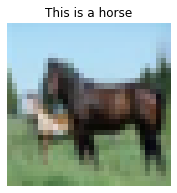

In [2]:
import matplotlib.pyplot as plt
from torchvision import datasets

# This is a convenient data reader.
categories = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']
train_data = datasets.CIFAR10('./datalab', train = True, download = True)

# This samples the 12-th image from the dataset.
# Try changing the index below to see different images in the dataset.
image, category = train_data[12]

# Display the image and its label.
plt.figure(figsize=(3,3))
plt.title('This is a %s' % categories[category])
plt.imshow(image); plt.grid('off');plt.axis('off')
plt.show()

##### **2.2 Convolutional Neural Network classifier**
In this section, you will define a convolutional neural network classifier and compute the accuracy of the model on CIFAR-10. Feel free to create any network that you consider would work well. You can get inspiration in some of the convolutional neural network architectures studied in class. I recommend you start with the LeNet architecture included below and start from there.

In [0]:
# Defining the model.
from tqdm import tqdm as tqdm
import torch.nn as nn
import torch.optim as optim

# LeNet is French for The Network, and is taken from Yann Lecun's 1998 paper
# on digit classification http://yann.lecun.com/exdb/lenet/
# This was also a network with just two convolutional layers.
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        # Convolutional layers.
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Linear layers.
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Conv1 + ReLU + MaxPooling.
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        
        # Conv2 + ReLU + MaPooling.
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        
        # This flattens the output of the previous layer into a vector.
        out = out.view(out.size(0), -1) 
        # Linear layer + ReLU.
        out = F.relu(self.fc1(out))
        # Another linear layer + ReLU.
        out = F.relu(self.fc2(out))
        # A final linear layer at the end.
        out = self.fc3(out)
       
        # We will not add nn.LogSoftmax here because nn.CrossEntropy has it.
        # Read the documentation for nn.CrossEntropy.
        return out
        
        
# Definition of our network.
classifier = LeNet()

#Definition of our loss.
criterion = nn.CrossEntropyLoss()

# Definition of optimization strategy.
# This optimizer has access to all the parameters in the model.
#
# It can zero all the parameters by doing:
#                                  optimizer.zero_grad()
#
# It can perform an SGD optimization update step in the direction of
# the gradients for each parameters by doing:
#                                  optimizer.step()
#
optimizer = optim.SGD(classifier.parameters(), lr = .01)

#### **3. Deep Convolutional Neural Networks**
In this section we will use a state-of-the-art deep neural network trained on the ILSVRC (Imagenet Large Scale Visual Recognition Challenge) dataset.




In this section we will experiment with a ResNet network with 50 layers of depth as seen during class. This network was trained in the ILSVRC task where it was trained on a million images each with one label belonging to 1000 possible classes. First let's load the pre-trained model that comes with Pytorch and categories vocabulary.

In [4]:
import torchvision.models as models

# Download list of 1000 categories for the ILSVRC task in right order.
!wget -nc http://www.cs.virginia.edu/~vicente/vision/imagenet_class_index.json
  
# Load the pre-trained model from the torchvision package.
resnet = models.resnet50(pretrained = True);
resnet.eval();  # Set in evaluation mode! In this case it matters.

--2019-11-17 23:28:16--  http://www.cs.virginia.edu/~vicente/vision/imagenet_class_index.json
Resolving www.cs.virginia.edu (www.cs.virginia.edu)... 128.143.67.11
Connecting to www.cs.virginia.edu (www.cs.virginia.edu)|128.143.67.11|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K)
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.09s   

2019-11-17 23:28:16 (377 KB/s) - ‘imagenet_class_index.json’ saved [35363/35363]



Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 87.7MB/s]


Now let's run an image through the network. Pay careful attention to all the steps.

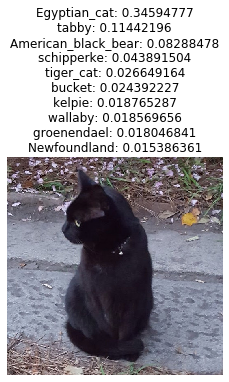

In [5]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.models as models
import json, io, requests, string
import torch.nn.functional as F
import torch

# 1. Define the appropriate image pre-processing function.
# This depends on the preprocessing function used during training. 
preprocessFn = transforms.Compose(
    [transforms.Resize(256), 
     transforms.CenterCrop(224), 
     transforms.ToTensor(), 
     transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                          std = [0.229, 0.224, 0.225])])

# 2. Load the imagenet class names.
imagenetClasses = {int(idx): entry[1] for (idx, entry) in 
                   json.load(open('imagenet_class_index.json')).items()}


# 3. Read image from URL into a PIL image type.
img_url = 'http://www.cs.virginia.edu/~vicente/vision/black-cat.jpg'
response = requests.get(img_url)
img_pil = Image.open(io.BytesIO(response.content))

# 4. Forward propagate the image through the CNN.
# Unsqueeze adds a dummy batch dimension needed to pass through the model.
inputVar =  preprocessFn(img_pil).unsqueeze(0)
predictions = resnet(inputVar)

# 5. Decode the top 10 classes predicted for this image.
# We need to apply softmax because the model outputs the last linear layer
# outputs and not softmax scores.
probs, indices = (-F.softmax(predictions, dim = 1).data).sort()
probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
preds = [imagenetClasses[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]

# 6. Show image and predictions
plt.title('\n'.join(preds))
plt.imshow(img_pil); plt.grid('off'); plt.axis('off');

### **Assignment Questions** (10pts)


#### **1. GPU Benchmarking** (1pts)
From the example code given in section 1, produce a plot using matplotlib that shows the execution time (y-axis) versus the size $d$ of the square matrices (x-axis) for both GPU and CPU (use values of $d$ = [10, 100, 1000, 5000, 10000]). Answer the following question: For what values of $d$ would you recommend using a GPU?

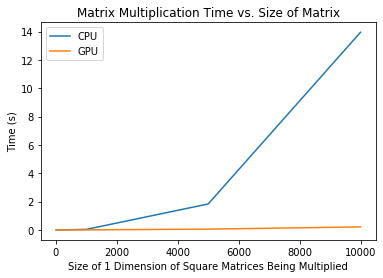

In [6]:
import torch
import time
import matplotlib.pyplot as plt
d  = [10, 100, 1000, 5000, 10000]
cpu_times = []
gpu_times = []
for dim in d:
  a = torch.rand(dim, dim)
  b = torch.rand(dim, dim)

  # Compute a dot product between the two matrices in CPU.
  start_time = time.time()
  output = torch.mm(a,b)  # Regular multiplication in CPU.
  cpu_times.append(time.time() - start_time)

  # Compute a dot product between the two matrices in GPU.
  start_time = time.time()
  a = a.cuda() # Move to GPU.
  b = b.cuda() # Move to GPU.
  output = torch.mm(a,b)  # Multiplication happens in GPU.
  gpu_times.append(time.time() - start_time)

plt.plot(d, cpu_times, label='CPU')
plt.plot(d, gpu_times, label='GPU')
plt.title('Matrix Multiplication Time vs. Size of Matrix')
plt.ylabel("Time (s)")
plt.xlabel("Size of 1 Dimension of Square Matrices Being Multiplied")
plt.legend()

Zooming in ...

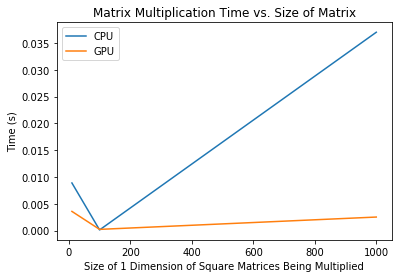

In [7]:
plt.plot(d[:3], cpu_times[:3], label='CPU')
plt.plot(d[:3], gpu_times[:3], label='GPU')
plt.title('Matrix Multiplication Time vs. Size of Matrix')
plt.ylabel("Time (s)")
plt.xlabel("Size of 1 Dimension of Square Matrices Being Multiplied")
plt.legend()

A GPU should be used to multiply 2 square matrices of equal size when the size of a dimension is > ~100. 

#### **2. Train a Modified version of LeNet on CIFAR-10** (3pts)
Propose and train a modified version of the LeNet CNN defined in this notebook on the CIFAR-10 dataset and compute the accuracy. Plot the loss for training and validation as training progresses (same as in the previous assignment), and the accuracy for training and validation (same as in the previous assignment). What is the final accuracy? Hints: Remember to use classifier.train() classifier.eval(), also remember to normalize the input data. Also, use the GPU.

In [0]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [9]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010))
])

train_data = datasets.CIFAR10(root='./datalab', train=True, download=True, transform=preprocess)
validation_data = datasets.CIFAR10(root='./datalab', train=False, download=True, transform=preprocess)

batch_size = 128 
trainLoader = DataLoader(train_data, batch_size = batch_size, 
                         shuffle = True, num_workers = 0)
valLoader = DataLoader(validation_data, batch_size = batch_size, 
                       shuffle = False, num_workers = 0)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
x, y = iter(trainLoader).next()
print('batch-of-images: ', x.shape)
print('batch-of-labels: ', y.shape)

batch-of-images:  torch.Size([128, 3, 32, 32])
batch-of-labels:  torch.Size([128])


In [0]:
def train_model(model, criterion, optimizer, 
                trainLoader, valLoader, n_epochs = 10):
  device = torch.device('cuda:0')
  model = model.to(device)
  training_accuracy = []
  training_loss = []
  validation_accuracy = []
  validation_loss = []

  for epoch in range(0, n_epochs):
    print('\nEpoch ', epoch+1)
    correct = 0
    cumloss = 0

    model.train()
    # Go over all the training data one batch at a time.
    for (i, (x, y)) in enumerate(trainLoader):
      x = x.cuda()
      y = y.cuda()
      
      yhat = model(x)
      loss = criterion(yhat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      with torch.no_grad():
        _, max_labels = yhat.max(1)   
        correct += (max_labels == y).sum().item() 
        cumloss += loss.item()
        
    n = len(train_data)
    train_accuracy = correct/n
    train_loss = cumloss/n
    training_accuracy.append(train_accuracy)
    print("Training Accuracy: ",  train_accuracy)
    training_loss.append(train_loss)
    print("Training Loss: ",  train_loss)

    correct = 0
    cumloss = 0
    model.eval()
    # Compute accuracy and loss on the validation set.
    with torch.no_grad(): 
      for (i, (x, y)) in enumerate(valLoader):
        x = x.cuda()
        y = y.cuda()
        
        yhat = model(x)
    
        _, max_labels = yhat.max(1)
        correct += (max_labels == y).sum().item()
        cumloss += loss.item()
    
    n = len(validation_data)
    val_accuracy = correct/n
    val_loss = cumloss/n
    validation_accuracy.append(val_accuracy)
    print("Validation Accuracy: ",  val_accuracy)
    validation_loss.append(val_loss)
    print("Validation Loss: ",  val_loss)

  epochs = list(range(n_epochs))
  fig = plt.figure(figsize = [15.0, 5.0])
  fig.subplots_adjust(hspace=.4, wspace=.4)
  fig.add_subplot(1,2,1)
  plt.plot(epochs, training_accuracy, label='Training Data')
  plt.plot(epochs, validation_accuracy, label = 'Validation Data')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')  
  plt.title('Accuracy vs. Epochs')
  plt.legend()
  fig.add_subplot(1,2,2)
  plt.plot(epochs, training_loss, label='Training Loss')
  plt.plot(epochs, validation_loss, label = 'Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')  
  plt.title('Loss vs. Epochs')
  plt.legend()


Epoch  1
Training Accuracy:  0.16624
Training Loss:  0.01789182819843292
Validation Accuracy:  0.2057
Validation Loss:  0.017513104033470155

Epoch  2
Training Accuracy:  0.2427
Training Loss:  0.01638348548412323
Validation Accuracy:  0.2874
Validation Loss:  0.015423756337165832

Epoch  3
Training Accuracy:  0.31566
Training Loss:  0.014761020390987397
Validation Accuracy:  0.3569
Validation Loss:  0.01459326263666153

Epoch  4
Training Accuracy:  0.37064
Training Loss:  0.013421360104084014
Validation Accuracy:  0.3964
Validation Loss:  0.01294484670162201

Epoch  5
Training Accuracy:  0.40578
Training Loss:  0.012653017547130585
Validation Accuracy:  0.4134
Validation Loss:  0.013464084315299987

Epoch  6
Training Accuracy:  0.4323
Training Loss:  0.012151562061309814
Validation Accuracy:  0.4201
Validation Loss:  0.01230266318321228

Epoch  7
Training Accuracy:  0.45654
Training Loss:  0.01173369464635849
Validation Accuracy:  0.4591
Validation Loss:  0.011722548747062684

Epoch 

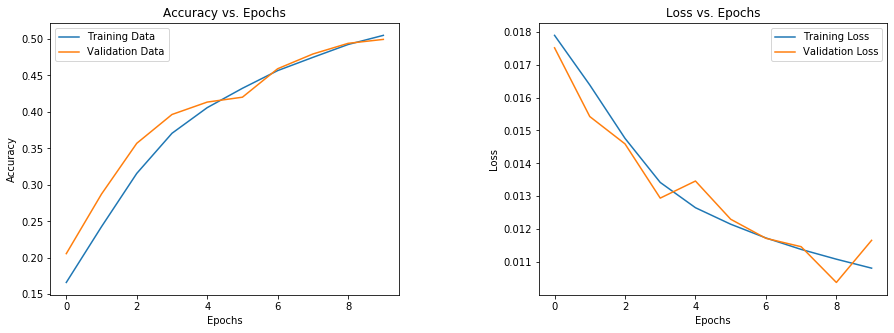

In [12]:
train_model(classifier, criterion, optimizer, trainLoader, valLoader, n_epochs = 10)

Final validation accuracy after 10 epochs is ~50%.

**Final Comments:** You should get a much better classification accuracy of this model. Try running it in some validation images and see how much better are the predictions of this model compared to the one used in a previous assignment.

#### **3. Use Alexnet to make some predictions** (2pts)

Take pictures of two objects for which the ResNet network trained on ILSVRC works really well and show the predictions, do the same for two objects for which the network doesn't do well. Take your own pictures of objects at your place, don't download images from the internet.

In [14]:
from google.colab import files
uploaded = files.upload()

Saving coffee maker.jpg to coffee maker.jpg
Saving corkscrew.jpg to corkscrew.jpg
Saving frying pan.jpg to frying pan.jpg
Saving lamp.jpg to lamp.jpg
Saving laptop.jpg to laptop.jpg
Saving saxophone.jpg to saxophone.jpg
Saving stove.jpg to stove.jpg
Saving wine bottle.jpg to wine bottle.jpg


In [0]:
from PIL import Image
import glob
image_list = []
for filename in glob.glob('/content/*.jpg'):
    im=Image.open(filename)
    im = im.transpose(Image.ROTATE_270)
    image_list.append(im)

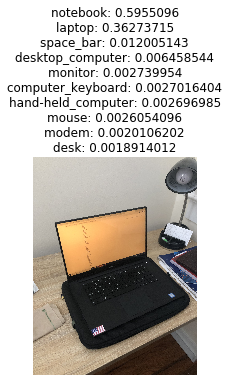

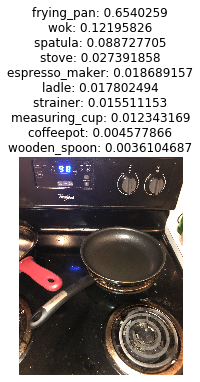

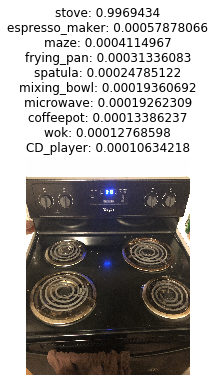

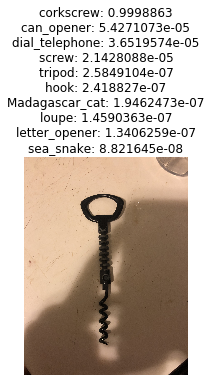

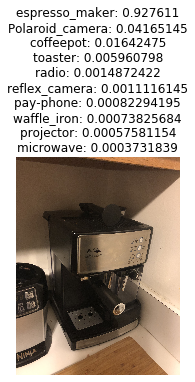

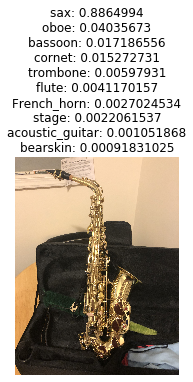

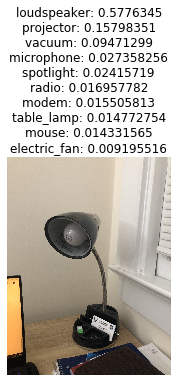

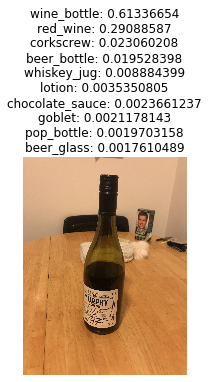

In [20]:
for i in range(len(image_list)):
  inputVar =  preprocessFn(image_list[i]).unsqueeze(0)
  predictions = resnet(inputVar)
  probs, indices = (-F.softmax(predictions, dim = 1).data).sort()
  probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
  preds = [imagenetClasses[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]
  plt.title('\n'.join(preds))
  plt.imshow(image_list[i]); plt.grid('off'); plt.axis('off');
  plt.show()

Correct Predictions: saxophone, stove, coffee maker, frying pan, corkscrew, wine bottle

Incorrect Predictions: lamp, laptop

#### **4. Cats vs Dogs** (4pts)
In this section "finetune" a resnet Convolutional Neural Network (CNN) on the Dogs vs Cats Kaggle competition dataset https://www.kaggle.com/c/dogs-vs-cats. "Finetuning" means you will load a pre-trained model and replace the last layer with a new classification (linear + softmax or logistic layer), and then modify the weights of the current network for the new task using SGD training. This should lead to better results than training the same network from random weights.  The training data in this dataset has 25,000 images, I already separated the images into training: 20,000 images and validation: 5,000 images. You can download my training, validation splits from the following dropbox link: [cats_dogs.zip](https://www.dropbox.com/s/sg7q9hhdzdxoeh2/cats_dogs.zip). You will have to write your own dataset class inheriting from torch.utils.data.Dataset, and a model that trains on this dataset. As usual, include plots making clear what is the accuracy that you achieved.

In [0]:
#Extracting images files from zip
!wget -nc https://www.dropbox.com/s/sg7q9hhdzdxoeh2/cats_dogs.zip && unzip cats_dogs.zip -d cats_dogs

Creating 2 dataframes, one for training and one for validation

In [0]:
import os
import pandas as pd

filenames_train = os.listdir("/content/cats_dogs/trainset")
categories = []
for filename in filenames_train:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

cats_dogs_train = pd.DataFrame.from_dict({
    'filename': filenames_train,
    'category': categories
})

In [0]:
os.remove("/content/cats_dogs/valset/.DS_Store")
filenames_val = os.listdir("/content/cats_dogs/valset")
categories = []
for filename in filenames_val:
  category = filename.split('.')[0]
  if category == 'dog':
      categories.append(1)
  else:
      categories.append(0)

cats_dogs_val = pd.DataFrame.from_dict({
    'filename': filenames_val,
    'category': categories
})

In [27]:
print(len(cats_dogs_train))
print(len(cats_dogs_val))

20000
5000


In [28]:
cats_dogs_train.head()

,filename,category
0,cat.4097.jpg,0
1,dog.4834.jpg,1
2,dog.2046.jpg,1
3,dog.3051.jpg,1
4,dog.12381.jpg,1


In [0]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2

class CatsAndDogs(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name)
        category = self.df.iloc[idx, 1:]
        category = int(category)

        if self.transform:
            image = self.transform(image)

        return image, category

In [0]:
import torchvision.transforms as transforms

preprocessFn = transforms.Compose(
    [transforms.Resize(256), 
     transforms.CenterCrop(224), 
     transforms.ToTensor(), 
     transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                          std = [0.229, 0.224, 0.225])])

In [0]:
#Creating datasets 
train = CatsAndDogs(df=cats_dogs_train, root_dir="/content/cats_dogs/trainset", transform=preprocessFn)
val = CatsAndDogs(df=cats_dogs_val, root_dir="/content/cats_dogs/valset", transform=preprocessFn)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
Dog


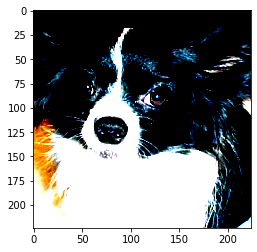

In [32]:
#sample image
import random
rnd = random.randint(0,20000)
img, label = train[rnd]
print(img.shape)
if label == 1:
  print("Dog")
else:
  print("Cat")
plt.imshow(img.permute(1, 2, 0))

In [33]:
batch_size = 128
trainLoader = DataLoader(train, batch_size = batch_size, 
                         shuffle = True, num_workers = 3)
valLoader = DataLoader(val, batch_size = batch_size, 
                       shuffle = False, num_workers = 3)

x, y = iter(trainLoader).next()
print('batch-of-images: ', x.shape)
print('batch-of-labels: ', y.shape)

batch-of-images:  torch.Size([128, 3, 224, 224])
batch-of-labels:  torch.Size([128])


In [0]:
#load a pretrained model
import torchvision.models as models
model = models.resnet50(pretrained = True);

In [40]:
import torch.nn as nn
from collections import OrderedDict
# replace the last layer with a linear layer
model.fc = nn.Linear(2048, 2)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
def train_model(model, criterion, optimizer, 
                trainLoader, valLoader, n_epochs = 10):
  device = torch.device('cuda:0')
  model = model.to(device)
  training_accuracy = []
  training_loss = []
  validation_accuracy = []
  validation_loss = []

  for epoch in range(0, n_epochs):
    print('\nEpoch ', epoch+1)
    correct = 0
    cumloss = 0

    model.train()
    # Go over all the training data one batch at a time.
    for (i, (x, y)) in enumerate(trainLoader):
      x = x.cuda()
      y = y.cuda()
      
      yhat = model(x)
      loss = criterion(yhat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      with torch.no_grad():
        _, max_labels = yhat.max(1)   
        correct += (max_labels == y).sum().item() 
        cumloss += loss.item()
        
    n = len(train)
    train_accuracy = correct/n
    train_loss = cumloss/n
    training_accuracy.append(train_accuracy)
    print("Training Accuracy: ",  train_accuracy)
    training_loss.append(train_loss)
    print("Training Loss: ",  train_loss)

    correct = 0
    cumloss = 0
    model.eval()
    # Compute accuracy and loss on the validation set.
    with torch.no_grad(): 
      for (i, (x, y)) in enumerate(valLoader):
        x = x.cuda()
        y = y.cuda()
        
        yhat = model(x)
    
        _, max_labels = yhat.max(1)
        correct += (max_labels == y).sum().item()
        cumloss += loss.item()
    
    n = len(val)
    val_accuracy = correct/n
    val_loss = cumloss/n
    validation_accuracy.append(val_accuracy)
    print("Validation Accuracy: ",  val_accuracy)
    validation_loss.append(val_loss)
    print("Validation Loss: ",  val_loss)

  epochs = list(range(n_epochs))
  fig = plt.figure(figsize = [15.0, 5.0])
  fig.subplots_adjust(hspace=.4, wspace=.4)
  fig.add_subplot(1,2,1)
  plt.plot(epochs, training_accuracy, label='Training Data')
  plt.plot(epochs, validation_accuracy, label = 'Validation Data')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')  
  plt.title('Accuracy vs. Epochs')
  plt.legend()
  fig.add_subplot(1,2,2)
  plt.plot(epochs, training_loss, label='Training Loss')
  plt.plot(epochs, validation_loss, label = 'Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')  
  plt.title('Loss vs. Epochs')
  plt.legend()


Epoch  1
Training Accuracy:  0.96395
Training Loss:  0.0016383991691982373
Validation Accuracy:  0.985
Validation Loss:  8.106231689453126e-09

Epoch  2
Training Accuracy:  0.98065
Training Loss:  0.0005576168248895556
Validation Accuracy:  0.9628
Validation Loss:  0.0015718173980712891

Epoch  3
Training Accuracy:  0.98235
Training Loss:  0.0004812523177359253
Validation Accuracy:  0.9862
Validation Loss:  0.00011800281703472137

Epoch  4
Training Accuracy:  0.9839
Training Loss:  0.0004222163987811655
Validation Accuracy:  0.9682
Validation Loss:  0.0018068830966949463

Epoch  5
Training Accuracy:  0.98325
Training Loss:  0.0003801395665272139
Validation Accuracy:  0.9866
Validation Loss:  0.0004891037344932557

Epoch  6
Training Accuracy:  0.98475
Training Loss:  0.00034941514742095023
Validation Accuracy:  0.9844
Validation Loss:  9.199380874633789e-07

Epoch  7
Training Accuracy:  0.9852
Training Loss:  0.0003197933085844852
Validation Accuracy:  0.9862
Validation Loss:  2.562689

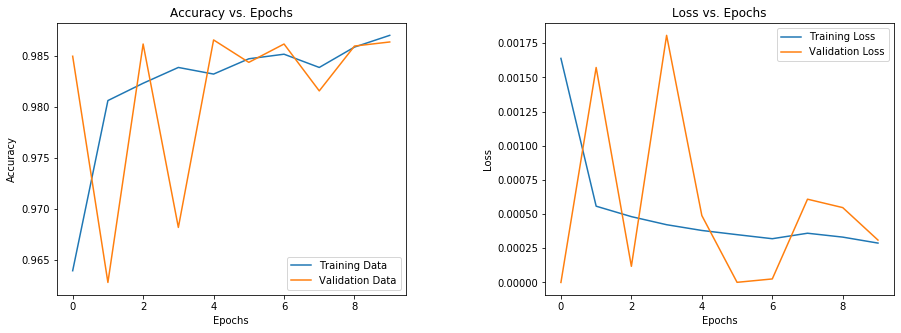

In [42]:
import torch.optim as optim
num_epochs = 10
optimizer = optim.SGD(model.fc.parameters(), lr=0.05, momentum=0.9, nesterov=True)
criterion = nn.CrossEntropyLoss()

train_model(model, criterion, optimizer, trainLoader, valLoader, n_epochs = num_epochs)

#### **5. Fine-tuning ResNet to the COCO-Dataset 80-category dataset**
Grading: 7pts - Optional for extra credit - but no partial credit on this question)

The COCO (Common Objects in Context) Dataset has 80 object categories. You can browse it here http://cocodataset.org/#home. This dataset also has bounding box annotations but we will not use them in this project. You will only map each image to an 80-dimensional vector where each entry corresponds to an object type, where the value is 1 if the object-type is present and 0 otherwise. (i.e. will not use box annotations, nor use the number of objects of each type). **Hints:** (1) To build the dataloader for COCO you can reuse the dataloder in pytorch for COCO but you need to modify it to return an 80-dimensional vector as label http://pytorch.org/docs/master/torchvision/datasets.html#coco (2) The 80-category prediction will require a different loss since these labels are not mutually exclusive, you will have to use torch.nn.BCEWithLogitsLoss. **Note:** For speed and in order to reduce network overhead use only 20,000 images for training, and 1,000 images for validation.

Show three example results of your trained model on the validation set of the COCO dataset. More especifically show the top ten predicted categories along with the score for each for three sample images.

In [0]:
#https://gluon-cv.mxnet.io/build/examples_datasets/mscoco.html
#https://stackoverflow.com/questions/50807254/how-to-download-and-use-object-detection-datasets-e-g-coco-or-pascal 
#https://medium.com/randomai/pytorch-torchvision-coco-dataset-b7f5e8cad82
coco_train = torchvision.datasets.CocoDetection(root = path2data, annFile = path2json)

In [0]:
# Getting data sets
!wget http://images.cocodataset.org/zips/train2017.zip && unzip train2017.zip -d train2017

In [0]:
!wget http://images.cocodataset.org/zips/val2017.zip && unzip val2017.zip -d val2017

**Final Comments:** In this section you learned to use a very deep neural network that was trained to recognize 1000 categories, then you finetuned this network to another dataset that only had 80 categories, and for a different criterion (loss function). How would you measure the accuracy of this model?